In [8]:
import numpy as np 
import pandas as pd 

import os
base_dir = r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection'
print(os.listdir(base_dir))

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

['code.ipynb', 'sample_submission.csv', 'test', 'train', 'train_labels.csv']


In [9]:
data = pd.read_csv('train_labels.csv')
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
print("Train Size: {}".format(len(os.listdir(r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/train/'))))
print("Test Size: {}".format(len(os.listdir(r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/test/'))))

Train Size: 220025
Test Size: 57458


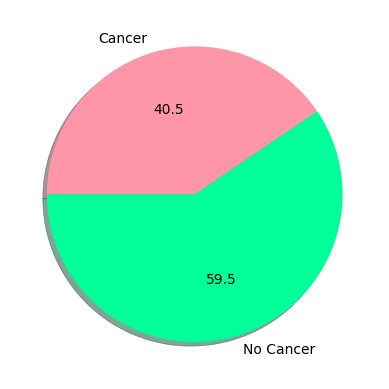

<Figure size 1600x1600 with 0 Axes>

In [11]:
labels_count = data.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

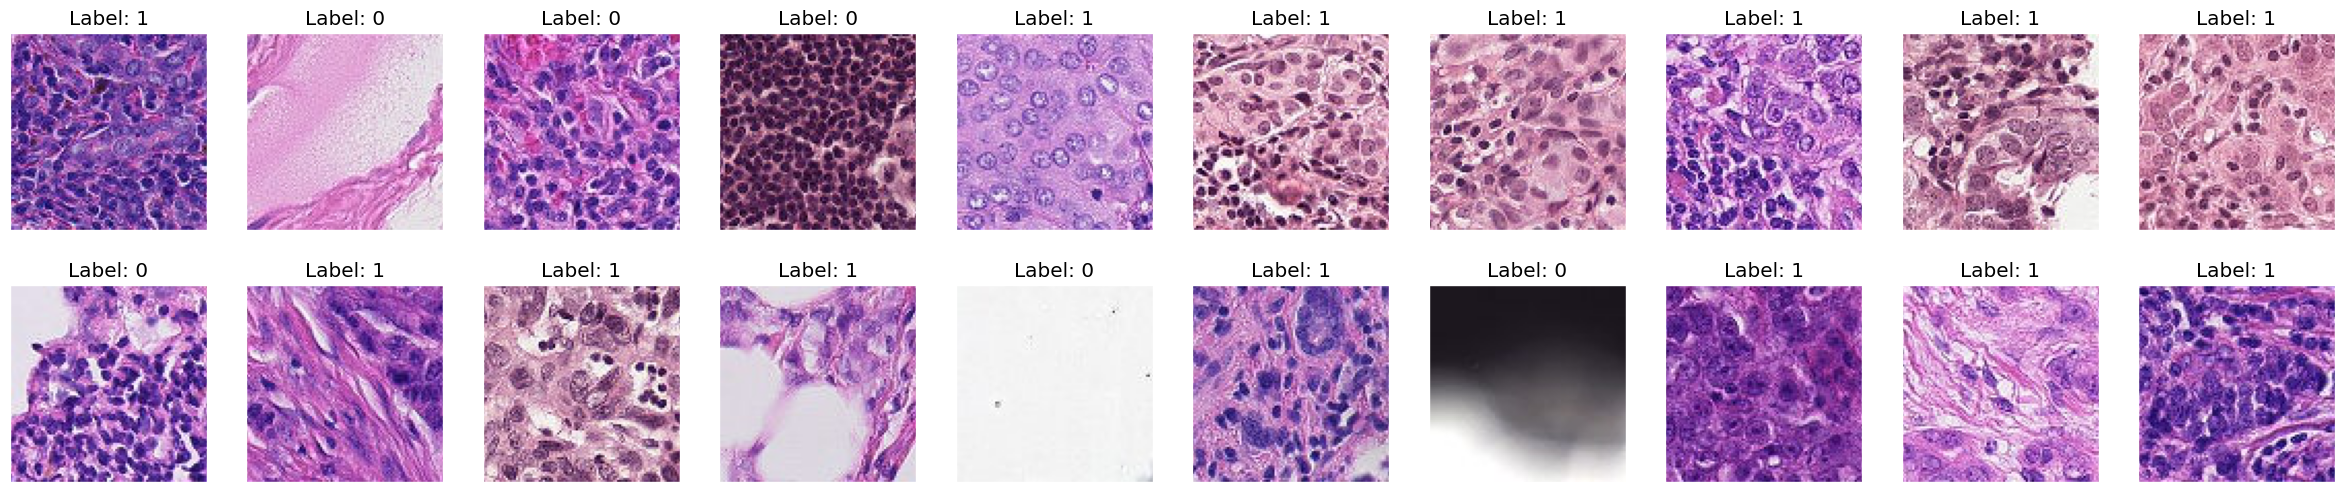

In [12]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/train/')
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/train/' + img)
    plt.imshow(im)
    lab = data.loc[data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [13]:
SAMPLE_SIZE = 80000

train_path = r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/train/'
test_path = r'C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/test/'

df_negatives = data[data['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = data[data['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

In [14]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [16]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [17]:
batch_size = 128

valid_size = 0.1

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [18]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

sample_sub = pd.read_csv(r"C:\Users\shaya\iCloudDrive\Histopathologic_Cancer_Detection\histopathologic-cancer-detection/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [21]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [22]:
model = CNN()
print(model)

if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [24]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [ ]:
n_epochs = 20

valid_loss_min = np.Inf

train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    

    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        target = target.view(-1, 1).float()  # Ensure target is float
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        

    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        target = target.view(-1, 1).float()  # Ensure target is float
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:, -1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))       
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

KeyboardInterrupt: 

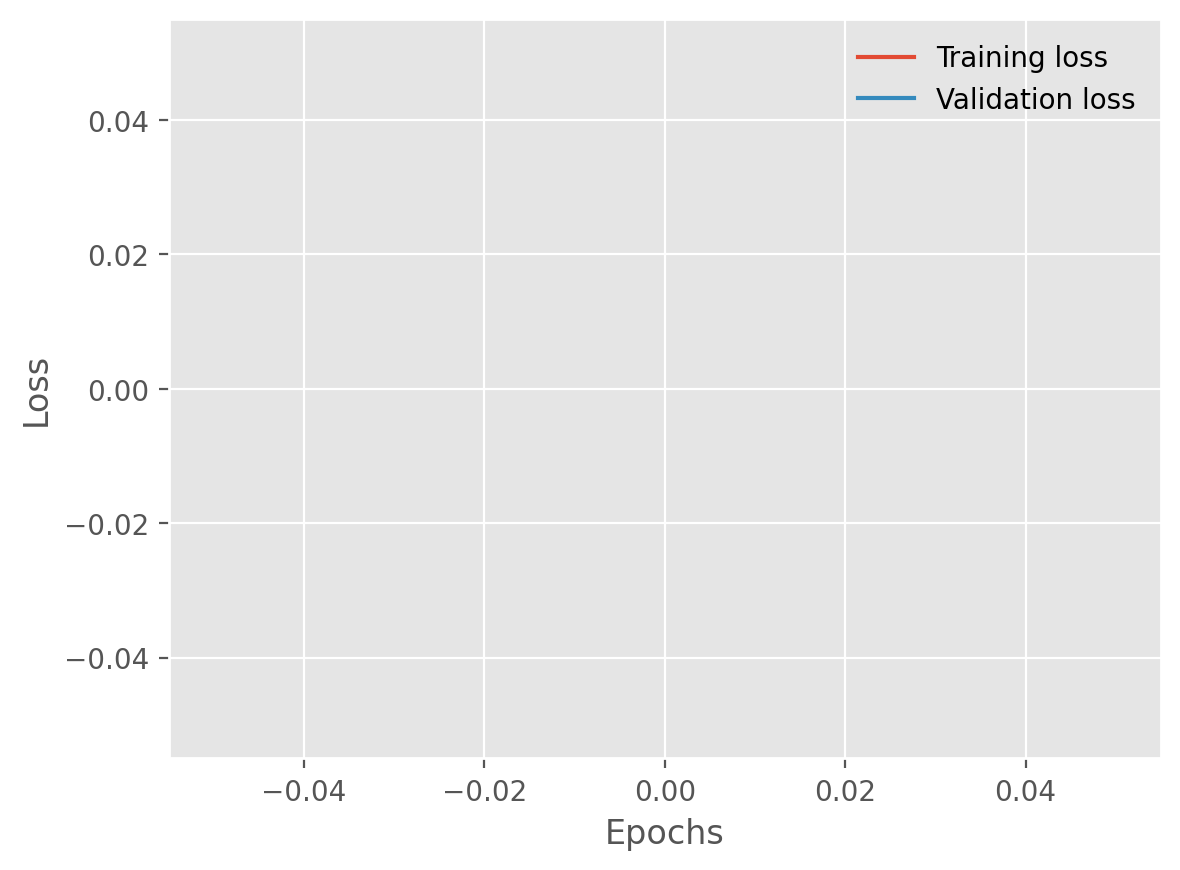

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [28]:
model.load_state_dict(torch.load('best_model.pt'))


C:\Users\shaya\AppData\Local\Temp\ipykernel_16308\3727638251.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'